In [1]:
import pandas as pd
import numpy as n
import ROOT as R
#R.enableJSVis()
R.ROOT.EnableImplicitMT()

c1=R.TCanvas('c1','c1',900,700)

t=R.TLatex()
t.SetTextSize(0.04)

graphs={}



Welcome to JupyROOT 6.18/04


In [2]:
#few functions definition

logit=R.TF1("logit","[0]/(1+TMath::Exp(-[1]*(x-[2])))",0,100)
logit.SetParameter(0,100)
logit.SetParLimits(0,0,10000)
logit.SetParameter(1,3)
logit.SetParLimits(1,0.,50.)
logit.SetParameter(2,5)
logit.SetParLimits(2,0.,200.)

f=R.TF1("ff","TMath::Exp((x+[0])/[1])",0,100)
f.SetParameter(0,13)
f.SetParLimits(0,-100,100)
f.SetParameter(1,4.5)
f.SetParLimits(1,1.,6.)

dgompertz= R.TF1('dgompertz','[0]*[1]*[2]*TMath::Exp(-[1]*TMath::Exp(-[2]*(x-[3]))-[2]*(x-[3]))',-100,100)
dgompertz.SetParameter(0,30000)
dgompertz.SetParLimits(0,0,100000)
dgompertz.SetParameter(2,0.1)
dgompertz.SetParLimits(2,0,10)
dgompertz.SetParameter(1,1)
dgompertz.SetParLimits(1,0,100)
dgompertz.SetParameter(3,10)
dgompertz.SetParLimits(3,5,20)


def rebinGraph(g,r,assignError):
    n=g.GetN()
    g1=R.TGraphErrors()
    g1.SetName(g.GetName()+'_rebin%d'%r)
    ibin=0
    average_Y=0
    average_X=0
    sumw2=0
    nbin=0
    for i in range(n):
        ibin+=1
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        average_X+=x
        w2=1/(g.GetErrorY(i)*g.GetErrorY(i))
        average_Y+=y*w2
        sumw2+=w2
        if (ibin>=r or i==n-1):
            average_Y=average_Y/sumw2
            average_X=average_X/ibin
            err_Y=R.TMath.Sqrt(1/sumw2)
            err_X=r/2.
            g1.SetPoint(nbin,average_X,average_Y)
            if (assignError):
                g1.SetPointError(nbin,err_X,err_Y)
            else:
                g1.SetPointError(nbin,0,0)
            nbin+=1
            ibin=0
            average_Y=0
            average_X=0
            sumw2=0
    return g1

def errorGraphBand(g,g2):
    n=g.GetN()
    g1=R.TGraphAsymmErrors(n)
    g1.SetName(g.GetName()+'_%s_error'%g2.GetName())
    ibin=0
    for i in range(n):
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        x1,y1=R.Double(0),R.Double(0)
        g2.GetPoint(i,x1,y1)
        #assign half difference one sided as error
        g1.SetPoint(i,x,y)
        g1.SetPointError(i,0.5,0.5,0.,(y1-y)*0.5)
    return g1


def integralGraph(g,firstPoint,lastPoint=-1):
    if (lastPoint==-1):
        lastPoint=g.GetN()
    integral=0
    error=0
    for i in range(firstPoint,lastPoint):
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        integral+=y
        error+=g.GetErrorY(i)*g.GetErrorY(i)
    return [integral,R.TMath.Sqrt(error)]

smooth=R.TGraphSmooth()
smooth1=R.TGraphSmooth()
smooth2=R.TGraphSmooth()

In [3]:
townRegion={
    'Brescia':'Lombardia',
    'Milano':'Lombardia',
    'Torino':'Piemonte',
    'Genova':'Liguria',
    'Roma':'Lazio'
}

townPopulation={
    'Brescia':196670,
    'Milano':1.352E6,
    'Torino':886837,
    'Genova':583601,
    'Roma':2.873E6
}

In [4]:
urlIstat = '~/Downloads/comuni_settimana.csv'
dfIstat = pd.read_csv(urlIstat)

In [5]:
urlIstatOld = '~/Downloads/comuni_settimana_old.csv'
dfIstatOld = pd.read_csv(urlIstatOld)

In [6]:
urlIstatOld2 = '~/Downloads/comuni_settimana_21_marzo.csv'
dfIstatOld2 = pd.read_csv(urlIstatOld2)

In [7]:
#Official data from http://www.epiprev.it/sites/default/files/SISMG_COVID19_28032020.pdf
urlByTown = 'mortalita_settimanale_per_citta.csv'
dfByTown = pd.read_csv(urlByTown)

In [8]:
#Official data from Protezione Civile
urlByProvince = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
urlNational = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
urlByRegion = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'


dfByProvince = pd.read_csv(urlByProvince,na_filter = False)
dfNational = pd.read_csv(urlNational)
dfByRegion = pd.read_csv(urlByRegion)

lastDate=dfNational['data'][len(dfNational)-1]

#dfByProvince.head(5)
#dfNational.head(5)

print("Last data %s"%lastDate)

Last data 2020-04-23T17:00:00


In [9]:
urlPopulation='comuni.csv'
dfByPopulation=pd.read_csv(urlPopulation)

#print(dfByPopulation.columns)
dfByPopulation['Totale']=dfByPopulation[['Totale Maschi','Totale Femmine']].sum(axis=1)
dfByPopulation=dfByPopulation[dfByPopulation['Età']==999]
#dfByPopulation=dfByPopulation.set_index('Denominazione')
dfByPopulation=dfByPopulation.drop(columns=['Età'])
dfByPopulation.head()

,Codice comune,Denominazione,Maschi celibi,Maschi coniugati,Maschi divorziati,Maschi vedovi,Maschi uniti civilmente,Maschi già in unione civile (per scioglimento),Maschi già in unione civile (per decesso del partner),Totale Maschi,Femmine nubili,Femmine coniugate,Femmine divorziate,Femmine vedove,Femmine unite civilmente,Femmine già in unione civile (per scioglimento),Femmine già in unione civile (per decesso del partner),Totale Femmine,Totale
101,1001,Agliè,540,602,46,49,NaN,NaN,NaN,1237,496,619,72,211,NaN,NaN,NaN,1398,2635
203,1002,Airasca,801,947,73,52,NaN,NaN,NaN,1873,637,950,58,163,NaN,NaN,NaN,1808,3681
305,1003,Ala di Stura,109,107,11,11,NaN,NaN,NaN,238,87,92,6,30,NaN,NaN,NaN,215,453
407,1004,Albiano d'Ivrea,349,395,36,28,NaN,NaN,NaN,808,282,399,39,118,NaN,NaN,NaN,838,1646
509,1006,Almese,1370,1552,111,88,NaN,NaN,NaN,3121,1164,1568,171,354,NaN,NaN,NaN,3257,6378


In [10]:
urlPopulationByRegion='regioni.csv'
dfPopulationByRegion=pd.read_csv(urlPopulationByRegion)

#print(dfPopulationByRegion.columns)
dfPopulationByRegion['Totale']=dfPopulationByRegion[['Totale Maschi','Totale Femmine']].sum(axis=1)
dfPopulationByRegion=dfPopulationByRegion[dfPopulationByRegion['Età']=='Totale']
#dfPopulationByRegion=dfPopulationByRegion.set_index('Denominazione')
dfPopulationByRegion=dfPopulationByRegion.drop(columns=['Età'])
dfPopulationByRegion.head()

,Regione,Maschi celibi,Maschi coniugati,Maschi divorziati,Maschi vedovi,Maschi uniti civilmente,Maschi già in unione civile (per scioglimento),Maschi già in unione civile (per decesso del partner),Totale Maschi,Femmine nubili,Femmine coniugate,Femmine divorziate,Femmine vedove,Femmine unite civilmente,Femmine già in unione civile (per scioglimento),Femmine già in unione civile (per decesso del partner),Totale Femmine,Totale
101,Piemonte,962714,1013052,75324,62849,1118,12,10,2115079,804470,1031805,107026,297391,620,14,1,2241327,4356406
203,Valle d'Aosta/Vallée d'Aoste,30180,26958,2623,1634,26,2,0,61423,25071,27486,3542,8126,16,2,0,64243,125666
305,Lombardia,2341426,2319286,140650,119919,3114,17,39,4924451,1984291,2358372,198515,593645,1253,18,29,5136123,10060574
407,Trentino-Alto Adige/Südtirol,271021,230664,15582,10730,209,0,4,528210,232930,234346,20811,55871,102,0,6,544066,1072276
509,Veneto,1126180,1150584,65721,56427,858,6,7,2399783,952850,1170382,89009,293396,425,4,5,2506071,4905854


In [11]:
regions = n.unique(dfIstat['NOME_REGIONE'])
#weeks=n.unique(dfIstat['SETTIMANA'])
weeks={'01/01-11/01':0 , '01/03-07/03':8, '02/02-08/02':4, '08/03-14/03':9, '09/02-15/02':5,
 '12/01-18/01':1, '15/03-21/03':10, '16/02-22/02':6, '19/01-25/01':2, '23/02-29/02':7,
 '26/01-01/02':3, '22/03-28/03':11,  '29/03-04/04':12}
ages=n.unique(dfIstat['CLASSE_DI_ETA'])
print(ages)
for w,index in weeks.items():
#    print(index,w)
    dfIstat=dfIstat.replace(w,index)

for a in ages:
    age=a
    index=int(n.where(ages == a)[0])
#    print(index,age)
    dfIstat=dfIstat.replace(age,index)

['0-14 anni' '15-64 anni' '65-74 anni' '75 anni e più']


In [12]:
for w,index in weeks.items():
#    print(index,w)
    dfIstatOld=dfIstatOld.replace(w,index)

for a in ages:
    age=a
    index=int(n.where(ages == a)[0])
#    print(index,age)
    dfIstatOld=dfIstatOld.replace(age,index)

In [13]:
for w,index in weeks.items():
#    print(index,w)
    dfIstatOld2=dfIstatOld2.replace(w,index)

for a in ages:
    age=a
    index=int(n.where(ages == a)[0])
#    print(index,age)
    dfIstatOld2=dfIstatOld2.replace(age,index)

In [14]:
dfIstat.head(30)

,REG,PROV,COD_PROVCOM,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,DATA_INIZIO_DIFF,SETTIMANA,CLASSE_DI_ETA,MASCHI_2015,...,FEMMINE_2017,FEMMINE_2018,FEMMINE_2019,FEMMINE_2020,TOTALE_2015,TOTALE_2016,TOTALE_2017,TOTALE_2018,TOTALE_2019,TOTALE_2020
0,1,1,1001,Piemonte,Torino,Agliè,1 aprile,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1001,Piemonte,Torino,Agliè,1 aprile,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1001,Piemonte,Torino,Agliè,1 aprile,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1001,Piemonte,Torino,Agliè,1 aprile,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1001,Piemonte,Torino,Agliè,1 aprile,4,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1001,Piemonte,Torino,Agliè,1 aprile,5,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1001,Piemonte,Torino,Agliè,1 aprile,6,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,1001,Piemonte,Torino,Agliè,1 aprile,7,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1001,Piemonte,Torino,Agliè,1 aprile,8,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1001,Piemonte,Torino,Agliè,1 aprile,9,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
townSisgmToAdd=['Torino','Roma']
townOldSisgmToAdd=['Torino','Roma']
townOld2SisgmToAdd=['Torino','Roma','Genova']
#townSisgmToAdd=[]


In [16]:
#organize Sisgm Data
df={}

provinces = n.unique(dfByTown['Town'])
for p in townOld2SisgmToAdd:
    df[p]=dfByTown[dfByTown['Town']==p]
    df[p]=df[p].drop(columns=['Town'])
    df[p]=df[p].transpose()
    df[p].columns=['number_of_deaths']
    #df[p]=df[p].set_index('week')

In [17]:
dfDeaths={}
graphs={}
firstWeek=4
for p in regions:
    print('=======',p)
    dfDeaths[p]=dfIstat[dfIstat['NOME_REGIONE']==p]
    graphs['deceduti_%s'%p]=R.TGraphErrors()
    graphs['deceduti_%s'%p].SetName('deceduti_%s'%p)
    for w in range(firstWeek,len(weeks)):
            d=int(dfDeaths[p].loc[dfDeaths[p]['SETTIMANA']==w]['TOTALE_2020'].sum())
            graphs['deceduti_%s'%p].SetPoint(w-firstWeek,w+1,d)
            graphs['deceduti_%s'%p].SetPointError(w-firstWeek,0.5,R.TMath.Sqrt(d))
            print(p,w+1,d)


======= Abruzzo
Abruzzo 5 44
Abruzzo 6 46
Abruzzo 7 39
Abruzzo 8 52
Abruzzo 9 57
Abruzzo 10 56
Abruzzo 11 66
Abruzzo 12 54
Abruzzo 13 41
======= Basilicata
Basilicata 5 10
Basilicata 6 17
Basilicata 7 7
Basilicata 8 17
Basilicata 9 10
Basilicata 10 20
Basilicata 11 16
Basilicata 12 9
Basilicata 13 20
======= Calabria
Calabria 5 26
Calabria 6 24
Calabria 7 15
Calabria 8 24
Calabria 9 20
Calabria 10 38
Calabria 11 33
Calabria 12 29
Calabria 13 35
======= Campania
Campania 5 55
Campania 6 51
Campania 7 54
Campania 8 59
Campania 9 62
Campania 10 64
Campania 11 65
Campania 12 70
Campania 13 60
======= Emilia-Romagna
Emilia-Romagna 5 618
Emilia-Romagna 6 627
Emilia-Romagna 7 614
Emilia-Romagna 8 683
Emilia-Romagna 9 773
Emilia-Romagna 10 1088
Emilia-Romagna 11 1442
Emilia-Romagna 12 1462
Emilia-Romagna 13 1107
======= Friuli-Venezia Giulia
Friuli-Venezia Giulia 5 30
Friuli-Venezia Giulia 6 15
Friuli-Venezia Giulia 7 27
Friuli-Venezia Giulia 8 18
Friuli-Venezia Giulia 9 35
Friuli-Venezia Giul

In [18]:
dfDeathsOld={}
for p in regions:
    print('=======',p)
    dfDeathsOld[p]=dfIstatOld[dfIstatOld['NOME_REGIONE']==p]
    graphs['deceduti_old_%s'%p]=R.TGraphErrors()
    graphs['deceduti_old_%s'%p].SetName('deceduti_old_%s'%p)
    for w in range(firstWeek,len(weeks)):
            d=int(dfDeathsOld[p].loc[dfDeathsOld[p]['SETTIMANA']==w]['TOTALE_2020'].sum())
            graphs['deceduti_old_%s'%p].SetPoint(w-firstWeek,w+1,d)
            graphs['deceduti_old_%s'%p].SetPointError(w-firstWeek,0.5,R.TMath.Sqrt(d))
            print(p,w+1,d)

======= Abruzzo
Abruzzo 5 44
Abruzzo 6 46
Abruzzo 7 39
Abruzzo 8 52
Abruzzo 9 57
Abruzzo 10 54
Abruzzo 11 66
Abruzzo 12 44
Abruzzo 13 0
======= Basilicata
Basilicata 5 10
Basilicata 6 11
Basilicata 7 5
Basilicata 8 15
Basilicata 9 8
Basilicata 10 17
Basilicata 11 14
Basilicata 12 5
Basilicata 13 0
======= Calabria
Calabria 5 13
Calabria 6 13
Calabria 7 9
Calabria 8 17
Calabria 9 18
Calabria 10 21
Calabria 11 21
Calabria 12 16
Calabria 13 0
======= Campania
Campania 5 41
Campania 6 37
Campania 7 38
Campania 8 44
Campania 9 56
Campania 10 49
Campania 11 51
Campania 12 50
Campania 13 0
======= Emilia-Romagna
Emilia-Romagna 5 493
Emilia-Romagna 6 522
Emilia-Romagna 7 490
Emilia-Romagna 8 547
Emilia-Romagna 9 646
Emilia-Romagna 10 944
Emilia-Romagna 11 1271
Emilia-Romagna 12 1237
Emilia-Romagna 13 0
======= Friuli-Venezia Giulia
Friuli-Venezia Giulia 5 28
Friuli-Venezia Giulia 6 15
Friuli-Venezia Giulia 7 25
Friuli-Venezia Giulia 8 17
Friuli-Venezia Giulia 9 31
Friuli-Venezia Giulia 10 29
F

In [19]:
dfDeathsOld2={}
for p in regions:
    print('=======',p)
    dfDeathsOld2[p]=dfIstatOld2[dfIstatOld2['NOME_REGIONE']==p]
    graphs['deceduti_Old2_%s'%p]=R.TGraphErrors()
    graphs['deceduti_Old2_%s'%p].SetName('deceduti_Old2_%s'%p)
    for w in range(firstWeek,len(weeks)):
            d=int(dfDeathsOld2[p].loc[dfDeathsOld2[p]['SETTIMANA']==w]['TOTALE_2020'].sum())
            graphs['deceduti_Old2_%s'%p].SetPoint(w-firstWeek,w+1,d)
            graphs['deceduti_Old2_%s'%p].SetPointError(w-firstWeek,0.5,R.TMath.Sqrt(d))
            print(p,w+1,d)

======= Abruzzo
Abruzzo 5 33
Abruzzo 6 30
Abruzzo 7 31
Abruzzo 8 34
Abruzzo 9 45
Abruzzo 10 38
Abruzzo 11 42
Abruzzo 12 0
Abruzzo 13 0
======= Basilicata
Basilicata 5 10
Basilicata 6 9
Basilicata 7 4
Basilicata 8 14
Basilicata 9 8
Basilicata 10 16
Basilicata 11 10
Basilicata 12 0
Basilicata 13 0
======= Calabria
Calabria 5 8
Calabria 6 11
Calabria 7 7
Calabria 8 13
Calabria 9 10
Calabria 10 16
Calabria 11 14
Calabria 12 0
Calabria 13 0
======= Campania
Campania 5 33
Campania 6 31
Campania 7 34
Campania 8 36
Campania 9 51
Campania 10 41
Campania 11 37
Campania 12 0
Campania 13 0
======= Emilia-Romagna
Emilia-Romagna 5 390
Emilia-Romagna 6 424
Emilia-Romagna 7 403
Emilia-Romagna 8 451
Emilia-Romagna 9 553
Emilia-Romagna 10 846
Emilia-Romagna 11 999
Emilia-Romagna 12 0
Emilia-Romagna 13 0
======= Friuli-Venezia Giulia
Friuli-Venezia Giulia 5 20
Friuli-Venezia Giulia 6 14
Friuli-Venezia Giulia 7 20
Friuli-Venezia Giulia 8 15
Friuli-Venezia Giulia 9 22
Friuli-Venezia Giulia 10 24
Friuli-Ven

In [20]:
#Add SigSM towns (missing from ISTAT)
sisgmFirstWeek=4
for p in townSisgmToAdd:
    print('======= %s'%p)
    for i,ni in enumerate(df[p]['number_of_deaths']):
        if (i>(len(weeks)-sisgmFirstWeek-1)):
            continue
        r=townRegion[p]
        x,y=R.Double(0),R.Double(0)
        graphs['deceduti_%s'%r].GetPoint(sisgmFirstWeek-firstWeek+i,x,y)
        y+=df[p]['number_of_deaths'][i]
        graphs['deceduti_%s'%r].SetPoint(i,i+sisgmFirstWeek+1,y)
        graphs['deceduti_%s'%r].SetPointError(i,0.5,R.TMath.Sqrt(y))
        print(p,r,i+sisgmFirstWeek+1,df[p]['number_of_deaths'][i],y)

======= Torino
Torino Piemonte 5 176.0 650.0
Torino Piemonte 6 183.0 616.0
Torino Piemonte 7 171.0 605.0
Torino Piemonte 8 174.0 621.0
Torino Piemonte 9 192.0 676.0
Torino Piemonte 10 210.0 782.0
Torino Piemonte 11 238.0 1004.0
Torino Piemonte 12 309.0 1234.0
Torino Piemonte 13 358.0 1132.0
======= Roma
Roma Lazio 5 484.0 527.0
Roma Lazio 6 506.0 555.0
Roma Lazio 7 453.0 488.0
Roma Lazio 8 480.0 519.0
Roma Lazio 9 483.0 517.0
Roma Lazio 10 490.0 541.0
Roma Lazio 11 540.0 603.0
Roma Lazio 12 521.0 566.0
Roma Lazio 13 547.0 580.0


In [21]:
#Add SigSM towns (missing from ISTAT)
for p in townOldSisgmToAdd:
    print('======= %s'%p)
    for i,ni in enumerate(df[p]['number_of_deaths']):
        if (i>(len(weeks)-sisgmFirstWeek-2)):
            continue
        r=townRegion[p]
        x,y=R.Double(0),R.Double(0)
        graphs['deceduti_old_%s'%r].GetPoint(sisgmFirstWeek-firstWeek+i,x,y)
        y+=df[p]['number_of_deaths'][i]
        graphs['deceduti_old_%s'%r].SetPoint(i,i+sisgmFirstWeek+1,y)
        graphs['deceduti_old_%s'%r].SetPointError(i,0.5,R.TMath.Sqrt(y))
        print(p,r,i+sisgmFirstWeek+1,df[p]['number_of_deaths'][i],y)

======= Torino
Torino Piemonte 5 176.0 576.0
Torino Piemonte 6 183.0 552.0
Torino Piemonte 7 171.0 534.0
Torino Piemonte 8 174.0 554.0
Torino Piemonte 9 192.0 611.0
Torino Piemonte 10 210.0 705.0
Torino Piemonte 11 238.0 927.0
Torino Piemonte 12 309.0 1084.0
======= Roma
Roma Lazio 5 484.0 525.0
Roma Lazio 6 506.0 554.0
Roma Lazio 7 453.0 488.0
Roma Lazio 8 480.0 515.0
Roma Lazio 9 483.0 516.0
Roma Lazio 10 490.0 538.0
Roma Lazio 11 540.0 600.0
Roma Lazio 12 521.0 564.0


In [22]:
#Add SigSM towns (missing from ISTAT)
for p in townOld2SisgmToAdd:
    print('======= %s'%p)
    for i,ni in enumerate(df[p]['number_of_deaths']):
        if (i>(len(weeks)-sisgmFirstWeek-3)):
            continue
        r=townRegion[p]
        x,y=R.Double(0),R.Double(0)
        graphs['deceduti_Old2_%s'%r].GetPoint(sisgmFirstWeek-firstWeek+i,x,y)
        y+=df[p]['number_of_deaths'][i]
        graphs['deceduti_Old2_%s'%r].SetPoint(i,i+sisgmFirstWeek+1,y)
        graphs['deceduti_Old2_%s'%r].SetPointError(i,0.5,R.TMath.Sqrt(y))
        print(p,r,i+sisgmFirstWeek+1,df[p]['number_of_deaths'][i],y)

======= Torino
Torino Piemonte 5 176.0 396.0
Torino Piemonte 6 183.0 394.0
Torino Piemonte 7 171.0 386.0
Torino Piemonte 8 174.0 389.0
Torino Piemonte 9 192.0 468.0
Torino Piemonte 10 210.0 538.0
Torino Piemonte 11 238.0 668.0
======= Roma
Roma Lazio 5 484.0 506.0
Roma Lazio 6 506.0 532.0
Roma Lazio 7 453.0 471.0
Roma Lazio 8 480.0 495.0
Roma Lazio 9 483.0 506.0
Roma Lazio 10 490.0 525.0
Roma Lazio 11 540.0 583.0
======= Genova
Genova Liguria 5 144.0 222.0
Genova Liguria 6 169.0 262.0
Genova Liguria 7 163.0 236.0
Genova Liguria 8 128.0 213.0
Genova Liguria 9 152.0 248.0
Genova Liguria 10 212.0 320.0
Genova Liguria 11 290.0 436.0


In [23]:
referenceWeek=5
for p in regions:
    graphs['deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerStyle(25)
    graphs['deceduti_%s'%p].SetMarkerSize(1.4)
    #Temporary: using as baseline fit of end of January/February data
    fB=R.TF1('fB','[0]*(1-0.0023*7*(x-%d))'%referenceWeek,0,100)
    graphs['deceduti_%s'%p].Fit('fB','RQB+','',referenceWeek-0.5,7.5)

    graphs['eccesso_deceduti_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_%s'%p].SetName('eccesso_deceduti_%s'%p)
    for w in range(0,graphs['deceduti_%s'%p].GetN()):
        x,y=R.Double(0),R.Double(0)
        yerr=graphs['deceduti_%s'%p].GetErrorY(w)
        graphs['deceduti_%s'%p].GetPoint(w,x,y)
        graphs['eccesso_deceduti_%s'%p].SetPoint(w,x,y-graphs['deceduti_%s'%p].GetFunction('fB').Eval(x))
        graphs['eccesso_deceduti_%s'%p].SetPointError(w,0.5,yerr)
    graphs['eccesso_deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerStyle(25)
    graphs['eccesso_deceduti_%s'%p].SetMarkerSize(1.4)

In [24]:
comuni = n.unique(dfIstat['NOME_COMUNE'])
comuniPopolazione = n.unique(dfByPopulation['Denominazione'])
pop=0

populationIstatByRegion={}
populationTotalByRegion={}

for r in regions:
    populationIstatByRegion[r]=0
    populationTotalByRegion[r]=0
    
for c in comuni:
    if c in comuniPopolazione:
       #print(c,n.array(dfByPopulation[dfByPopulation['Denominazione']==c]['Totale'])[0])
        p=n.array(dfByPopulation[dfByPopulation['Denominazione']==c]['Totale'])[0]
        r=str(n.unique(dfIstat[dfIstat['NOME_COMUNE']==c]['NOME_REGIONE'])[0])
        if(pd.isnull(p)):
            continue
        pop+=p
        populationIstatByRegion[r]+=p

print('DB Istat population: %d Comuni: %d'%(pop,len(comuni)))
print(populationIstatByRegion)

DB Istat population: 19304439 Comuni: 1689
{'Abruzzo': 170540, 'Basilicata': 46649, 'Calabria': 98955, 'Campania': 258209, 'Emilia-Romagna': 2718973, 'Friuli-Venezia Giulia': 118647, 'Lazio': 184596, 'Liguria': 1071658, 'Lombardia': 7262054, 'Marche': 513284, 'Molise': 26577, 'Piemonte': 1693222, 'Puglia': 749628, 'Sardegna': 388492, 'Sicilia': 361721, 'Toscana': 1174102, 'Trentino-Alto Adige/Südtirol': 203398, 'Umbria': 211428, "Valle d'Aosta/Vallée d'Aoste": 49570, 'Veneto': 2002736}


In [25]:
comuniOld = n.unique(dfIstatOld['NOME_COMUNE'])
popOld=0

populationOldIstatByRegion={}
populationOldTotalByRegion={}

for r in regions:
    populationOldIstatByRegion[r]=0
    populationOldTotalByRegion[r]=0
    
for c in comuniOld:
    if c in comuniPopolazione:
       #print(c,n.array(dfByPopulation[dfByPopulation['Denominazione']==c]['Totale'])[0])
        p=n.array(dfByPopulation[dfByPopulation['Denominazione']==c]['Totale'])[0]
        r=str(n.unique(dfIstatOld[dfIstatOld['NOME_COMUNE']==c]['NOME_REGIONE'])[0])
        if(pd.isnull(p)):
            continue
        popOld+=p
        populationOldIstatByRegion[r]+=p

print('DB IstatOld population: %d Comuni: %d'%(popOld,len(comuniOld)))
print(populationOldIstatByRegion)

DB IstatOld population: 17047682 Comuni: 1450
{'Abruzzo': 170540, 'Basilicata': 35507, 'Calabria': 58593, 'Campania': 198997, 'Emilia-Romagna': 2223875, 'Friuli-Venezia Giulia': 107270, 'Lazio': 172113, 'Liguria': 1039816, 'Lombardia': 6742951, 'Marche': 478153, 'Molise': 26577, 'Piemonte': 1414378, 'Puglia': 690710, 'Sardegna': 262664, 'Sicilia': 332775, 'Toscana': 1030982, 'Trentino-Alto Adige/Südtirol': 151330, 'Umbria': 211428, "Valle d'Aosta/Vallée d'Aoste": 46937, 'Veneto': 1652086}


In [26]:
comuniOld2 = n.unique(dfIstatOld2['NOME_COMUNE'])
popOld2=0

populationOld2IstatByRegion={}
populationOld2TotalByRegion={}

for r in regions:
    populationOld2IstatByRegion[r]=0
    populationOld2TotalByRegion[r]=0
    
for c in comuniOld2:
    if c in comuniPopolazione:
       #print(c,n.array(dfByPopulation[dfByPopulation['Denominazione']==c]['Totale'])[0])
        p=n.array(dfByPopulation[dfByPopulation['Denominazione']==c]['Totale'])[0]
        r=str(n.unique(dfIstatOld2[dfIstatOld2['NOME_COMUNE']==c]['NOME_REGIONE'])[0])
        if(pd.isnull(p)):
            continue
        popOld2+=p
        populationOld2IstatByRegion[r]+=p

print('DB IstatOld2 population: %d Comuni: %d'%(popOld2,len(comuniOld2)))
print(populationOld2IstatByRegion)

DB IstatOld2 population: 12673821 Comuni: 1084
{'Abruzzo': 116517, 'Basilicata': 33189, 'Calabria': 36136, 'Campania': 162206, 'Emilia-Romagna': 1845733, 'Friuli-Venezia Giulia': 87426, 'Lazio': 105592, 'Liguria': 308969, 'Lombardia': 5681943, 'Marche': 361387, 'Molise': 24746, 'Piemonte': 809268, 'Puglia': 415558, 'Sardegna': 175277, 'Sicilia': 267311, 'Toscana': 835730, 'Trentino-Alto Adige/Südtirol': 103821, 'Umbria': 194554, "Valle d'Aosta/Vallée d'Aoste": 38856, 'Veneto': 1069602}


In [27]:
for p in townSisgmToAdd:
    print(p)
    populationIstatByRegion[townRegion[p]]+=townPopulation[p]

Torino
Roma


In [28]:
for p in townOldSisgmToAdd:
    print(p)
    populationOldIstatByRegion[townRegion[p]]+=townPopulation[p]

Torino
Roma


In [29]:
for p in townOld2SisgmToAdd:
    print(p)
    populationOld2IstatByRegion[townRegion[p]]+=townPopulation[p]

Torino
Roma
Genova


In [30]:
print(populationIstatByRegion)

{'Abruzzo': 170540, 'Basilicata': 46649, 'Calabria': 98955, 'Campania': 258209, 'Emilia-Romagna': 2718973, 'Friuli-Venezia Giulia': 118647, 'Lazio': 3057596.0, 'Liguria': 1071658, 'Lombardia': 7262054, 'Marche': 513284, 'Molise': 26577, 'Piemonte': 2580059, 'Puglia': 749628, 'Sardegna': 388492, 'Sicilia': 361721, 'Toscana': 1174102, 'Trentino-Alto Adige/Südtirol': 203398, 'Umbria': 211428, "Valle d'Aosta/Vallée d'Aoste": 49570, 'Veneto': 2002736}


In [31]:
print(populationOldIstatByRegion)

{'Abruzzo': 170540, 'Basilicata': 35507, 'Calabria': 58593, 'Campania': 198997, 'Emilia-Romagna': 2223875, 'Friuli-Venezia Giulia': 107270, 'Lazio': 3045113.0, 'Liguria': 1039816, 'Lombardia': 6742951, 'Marche': 478153, 'Molise': 26577, 'Piemonte': 2301215, 'Puglia': 690710, 'Sardegna': 262664, 'Sicilia': 332775, 'Toscana': 1030982, 'Trentino-Alto Adige/Südtirol': 151330, 'Umbria': 211428, "Valle d'Aosta/Vallée d'Aoste": 46937, 'Veneto': 1652086}


In [32]:
print(populationOld2IstatByRegion)

{'Abruzzo': 116517, 'Basilicata': 33189, 'Calabria': 36136, 'Campania': 162206, 'Emilia-Romagna': 1845733, 'Friuli-Venezia Giulia': 87426, 'Lazio': 2978592.0, 'Liguria': 892570, 'Lombardia': 5681943, 'Marche': 361387, 'Molise': 24746, 'Piemonte': 1696105, 'Puglia': 415558, 'Sardegna': 175277, 'Sicilia': 267311, 'Toscana': 835730, 'Trentino-Alto Adige/Südtirol': 103821, 'Umbria': 194554, "Valle d'Aosta/Vallée d'Aoste": 38856, 'Veneto': 1069602}


In [33]:
for r in n.unique(dfPopulationByRegion['Regione']):
    p=int(dfPopulationByRegion[dfPopulationByRegion['Regione']==r]['Totale'])
    if(pd.isnull(p)):
        continue
    populationTotalByRegion[r]=p
print(populationTotalByRegion)

{'Abruzzo': 1311580, 'Basilicata': 562869, 'Calabria': 1947131, 'Campania': 5801692, 'Emilia-Romagna': 4459477, 'Friuli-Venezia Giulia': 1215220, 'Lazio': 5879082, 'Liguria': 1550640, 'Lombardia': 10060574, 'Marche': 1525271, 'Molise': 305617, 'Piemonte': 4356406, 'Puglia': 4029053, 'Sardegna': 1639591, 'Sicilia': 4999891, 'Toscana': 3729641, 'Trentino-Alto Adige/Südtirol': 1072276, 'Umbria': 882015, "Valle d'Aosta/Vallée d'Aoste": 125666, 'Veneto': 4905854}


In [34]:
print(n.asarray([n for i,n in populationIstatByRegion.items()]).sum())

23064276.0


In [35]:
rescalingFactor={}
for r in n.unique(dfPopulationByRegion['Regione']):
    rescalingFactor[r]=float(populationIstatByRegion[r])/populationTotalByRegion[r]
print(['%s:%.3f'%(r,f) for r,f in rescalingFactor.items()])

['Abruzzo:0.130', 'Basilicata:0.083', 'Calabria:0.051', 'Campania:0.045', 'Emilia-Romagna:0.610', 'Friuli-Venezia Giulia:0.098', 'Lazio:0.520', 'Liguria:0.691', 'Lombardia:0.722', 'Marche:0.337', 'Molise:0.087', 'Piemonte:0.592', 'Puglia:0.186', 'Sardegna:0.237', 'Sicilia:0.072', 'Toscana:0.315', 'Trentino-Alto Adige/Südtirol:0.190', 'Umbria:0.240', "Valle d'Aosta/Vallée d'Aoste:0.394", 'Veneto:0.408']


In [36]:
rescalingFactorNewOld={}
for r in n.unique(dfPopulationByRegion['Regione']):
    rescalingFactorNewOld[r]=float(populationIstatByRegion[r])/populationOldIstatByRegion[r]
print(['%s:%.3f'%(r,f) for r,f in rescalingFactorNewOld.items()])

['Abruzzo:1.000', 'Basilicata:1.314', 'Calabria:1.689', 'Campania:1.298', 'Emilia-Romagna:1.223', 'Friuli-Venezia Giulia:1.106', 'Lazio:1.004', 'Liguria:1.031', 'Lombardia:1.077', 'Marche:1.073', 'Molise:1.000', 'Piemonte:1.121', 'Puglia:1.085', 'Sardegna:1.479', 'Sicilia:1.087', 'Toscana:1.139', 'Trentino-Alto Adige/Südtirol:1.344', 'Umbria:1.000', "Valle d'Aosta/Vallée d'Aoste:1.056", 'Veneto:1.212']


In [37]:
rescalingFactorNewOld2={}
for r in n.unique(dfPopulationByRegion['Regione']):
    rescalingFactorNewOld2[r]=float(populationIstatByRegion[r])/populationOld2IstatByRegion[r]
print(['%s:%.3f'%(r,f) for r,f in rescalingFactorNewOld2.items()])

['Abruzzo:1.464', 'Basilicata:1.406', 'Calabria:2.738', 'Campania:1.592', 'Emilia-Romagna:1.473', 'Friuli-Venezia Giulia:1.357', 'Lazio:1.027', 'Liguria:1.201', 'Lombardia:1.278', 'Marche:1.420', 'Molise:1.074', 'Piemonte:1.521', 'Puglia:1.804', 'Sardegna:2.216', 'Sicilia:1.353', 'Toscana:1.405', 'Trentino-Alto Adige/Südtirol:1.959', 'Umbria:1.087', "Valle d'Aosta/Vallée d'Aoste:1.276", 'Veneto:1.872']


In [38]:
for p in regions:
    print('=======',p)
    graphs['deceduti_old_rescaled_%s'%p]=R.TGraphErrors()
    graphs['deceduti_old_rescaled_%s'%p].SetName('deceduti_old_rescaled_%s'%p)
    for w in range(firstWeek,len(weeks)):
            x,y=R.Double(0),R.Double(0)
            yerr=graphs['deceduti_old_%s'%p].GetErrorY(w-firstWeek)
            graphs['deceduti_old_%s'%p].GetPoint(w-firstWeek,x,y)
            graphs['deceduti_old_rescaled_%s'%p].SetPoint(w-firstWeek,x,y*rescalingFactorNewOld[p])
            graphs['deceduti_old_rescaled_%s'%p].SetPointError(w-firstWeek,0.5,yerr*rescalingFactorNewOld[p])
            print(p,x,y*rescalingFactorNewOld[p])

======= Abruzzo
Abruzzo 5.0 44.0
Abruzzo 6.0 46.0
Abruzzo 7.0 39.0
Abruzzo 8.0 52.0
Abruzzo 9.0 57.0
Abruzzo 10.0 54.0
Abruzzo 11.0 66.0
Abruzzo 12.0 44.0
Abruzzo 13.0 0.0
======= Basilicata
Basilicata 5.0 13.137972794096939
Basilicata 6.0 14.451770073506633
Basilicata 7.0 6.568986397048469
Basilicata 8.0 19.70695919114541
Basilicata 9.0 10.510378235277551
Basilicata 10.0 22.334553749964797
Basilicata 11.0 18.393161911735714
Basilicata 12.0 6.568986397048469
Basilicata 13.0 0.0
======= Calabria
Calabria 5.0 21.955097025241923
Calabria 6.0 21.955097025241923
Calabria 7.0 15.199682555936716
Calabria 8.0 28.71051149454713
Calabria 9.0 30.399365111873433
Calabria 10.0 35.465925963852335
Calabria 11.0 35.465925963852335
Calabria 12.0 27.02165787722083
Calabria 13.0 0.0
======= Campania
Campania 5.0 53.19964120062111
Campania 6.0 48.00943230299954
Campania 7.0 49.306984527404936
Campania 8.0 57.09229787383729
Campania 9.0 72.662924566702
Campania 10.0 63.580058995864256
Campania 11.0 66.1751

In [39]:
for p in regions:
    print('=======',p)
    graphs['deceduti_Old2_rescaled_%s'%p]=R.TGraphErrors()
    graphs['deceduti_Old2_rescaled_%s'%p].SetName('deceduti_Old2_rescaled_%s'%p)
    for w in range(firstWeek,len(weeks)):
            x,y=R.Double(0),R.Double(0)
            yerr=graphs['deceduti_Old2_%s'%p].GetErrorY(w-firstWeek)
            graphs['deceduti_Old2_%s'%p].GetPoint(w-firstWeek,x,y)
            graphs['deceduti_Old2_rescaled_%s'%p].SetPoint(w-firstWeek,x,y*rescalingFactorNewOld2[p])
            graphs['deceduti_Old2_rescaled_%s'%p].SetPointError(w-firstWeek,0.5,yerr*rescalingFactorNewOld2[p])
            print(p,x,y*rescalingFactorNewOld2[p])

======= Abruzzo
Abruzzo 5.0 48.30041968124823
Abruzzo 6.0 43.90947243749839
Abruzzo 7.0 45.373121518748334
Abruzzo 8.0 49.76406876249818
Abruzzo 9.0 65.86420865624758
Abruzzo 10.0 55.61866508749796
Abruzzo 11.0 61.47326141249774
Abruzzo 12.0 0.0
Abruzzo 13.0 0.0
======= Basilicata
Basilicata 5.0 14.055560577299708
Basilicata 6.0 12.650004519569737
Basilicata 7.0 5.622224230919883
Basilicata 8.0 19.67778480821959
Basilicata 9.0 11.244448461839767
Basilicata 10.0 22.488896923679533
Basilicata 11.0 14.055560577299708
Basilicata 12.0 0.0
Basilicata 13.0 0.0
======= Calabria
Calabria 5.0 21.907239318131502
Calabria 6.0 30.122454062430815
Calabria 7.0 19.168834403365064
Calabria 8.0 35.59926389196369
Calabria 9.0 27.384049147664378
Calabria 10.0 43.814478636263004
Calabria 11.0 38.33766880673013
Calabria 12.0 0.0
Calabria 13.0 0.0
======= Campania
Campania 5.0 52.531330530313305
Campania 6.0 49.34761352847614
Campania 7.0 54.12318903123189
Campania 8.0 57.30690603306906
Campania 9.0 81.18478

In [40]:
for p in regions:
    print('=======',p)
    for w in range(firstWeek,len(weeks)):
            x,y=R.Double(0),R.Double(0)
            yerr=graphs['deceduti_%s'%p].GetErrorY(w-firstWeek)
            graphs['deceduti_%s'%p].GetPoint(w-firstWeek,x,y)
            print(p,x,y)

======= Abruzzo
Abruzzo 5.0 44.0
Abruzzo 6.0 46.0
Abruzzo 7.0 39.0
Abruzzo 8.0 52.0
Abruzzo 9.0 57.0
Abruzzo 10.0 56.0
Abruzzo 11.0 66.0
Abruzzo 12.0 54.0
Abruzzo 13.0 41.0
======= Basilicata
Basilicata 5.0 10.0
Basilicata 6.0 17.0
Basilicata 7.0 7.0
Basilicata 8.0 17.0
Basilicata 9.0 10.0
Basilicata 10.0 20.0
Basilicata 11.0 16.0
Basilicata 12.0 9.0
Basilicata 13.0 20.0
======= Calabria
Calabria 5.0 26.0
Calabria 6.0 24.0
Calabria 7.0 15.0
Calabria 8.0 24.0
Calabria 9.0 20.0
Calabria 10.0 38.0
Calabria 11.0 33.0
Calabria 12.0 29.0
Calabria 13.0 35.0
======= Campania
Campania 5.0 55.0
Campania 6.0 51.0
Campania 7.0 54.0
Campania 8.0 59.0
Campania 9.0 62.0
Campania 10.0 64.0
Campania 11.0 65.0
Campania 12.0 70.0
Campania 13.0 60.0
======= Emilia-Romagna
Emilia-Romagna 5.0 618.0
Emilia-Romagna 6.0 627.0
Emilia-Romagna 7.0 614.0
Emilia-Romagna 8.0 683.0
Emilia-Romagna 9.0 773.0
Emilia-Romagna 10.0 1088.0
Emilia-Romagna 11.0 1442.0
Emilia-Romagna 12.0 1462.0
Emilia-Romagna 13.0 1107.0
====

In [41]:
R.gStyle.SetOptFit(0)

graphs['newold_lastPoint']=R.TH1F('newold_lastPoint','newold_lastPoint',40,0.7,1.5)
for p in regions:
    print('=======',p)
    graphs['deceduti_newold_ratio_%s'%p]=R.TGraphErrors()
    graphs['deceduti_newold_ratio_%s'%p].SetName('deceduti_newold_ratio_%s'%p)
    for w in range(firstWeek,len(weeks)-1):
            x,y=R.Double(0),R.Double(0)
            yerr=graphs['deceduti_%s'%p].GetErrorY(w-firstWeek)
            xold,yold=R.Double(0),R.Double(0)
            yolderr=graphs['deceduti_old_%s'%p].GetErrorY(w-firstWeek) 
            graphs['deceduti_%s'%p].GetPoint(w-firstWeek,x,y)
            graphs['deceduti_old_rescaled_%s'%p].GetPoint(w-firstWeek,xold,yold)
            if (yold==0):
                continue
            ratioerr=y/yold*R.TMath.Sqrt((yerr/y)**2+(yolderr/yold)**2)/4 #approximate error, as values correlated
            graphs['deceduti_newold_ratio_%s'%p].SetPoint(w-firstWeek,x,y/yold)
            graphs['deceduti_newold_ratio_%s'%p].SetPointError(w-firstWeek,0.5,ratioerr)
            if (w==len(weeks)-2 and rescalingFactor[p]>0.6):
                graphs['newold_lastPoint'].Fill(y/yold)
            print(p,x,y/yold,ratioerr)

    graphs['deceduti_newold2_ratio_%s'%p]=R.TGraphErrors()
    graphs['deceduti_newold2_ratio_%s'%p].SetName('deceduti_newold2_ratio_%s'%p)
    for w in range(firstWeek,len(weeks)-2):
            x,y=R.Double(0),R.Double(0)
            yerr=graphs['deceduti_old_rescaled_%s'%p].GetErrorY(w-firstWeek)
            xold,yold=R.Double(0),R.Double(0)
            yolderr=graphs['deceduti_Old2_%s'%p].GetErrorY(w-firstWeek) 
            graphs['deceduti_old_rescaled_%s'%p].GetPoint(w-firstWeek,x,y)
            graphs['deceduti_Old2_rescaled_%s'%p].GetPoint(w-firstWeek,xold,yold)
            if (yold==0):
                continue
            ratioerr=y/yold*R.TMath.Sqrt((yerr/y)**2+(yolderr/yold)**2)/4 #approximate error, as values correlated
            graphs['deceduti_newold2_ratio_%s'%p].SetPoint(w-firstWeek,x,y/yold)
            graphs['deceduti_newold2_ratio_%s'%p].SetPointError(w-firstWeek,0.5,ratioerr)
            if (w==len(weeks)-3 and rescalingFactor[p]>0.6):
                graphs['newold_lastPoint'].Fill(y/yold)
            print(p,x,y/yold,ratioerr)


    graphs['deceduti_newold_ratio_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_newold_ratio_%s'%p].SetMarkerStyle(20)
    graphs['deceduti_newold_ratio_%s'%p].SetMarkerSize(1.6)
    
    
    graphs['deceduti_newold2_ratio_%s'%p].SetMarkerColor(R.kRed)
    graphs['deceduti_newold2_ratio_%s'%p].SetLineColor(R.kRed)
    graphs['deceduti_newold2_ratio_%s'%p].SetMarkerStyle(20)
    graphs['deceduti_newold2_ratio_%s'%p].SetMarkerSize(1.6)
    
    graphs['deceduti_newold_ratio_%s'%p].GetYaxis().SetLimits(0.7,1.4)
    graphs['deceduti_newold_ratio_%s'%p].GetYaxis().SetRangeUser(0.7,1.4)
    graphs['deceduti_newold_ratio_%s'%p].Draw('AP')
    graphs['deceduti_newold2_ratio_%s'%p].Draw('PSAME')
    #graphs['deceduti_newold_ratio_%s'%p].Fit('pol0')
    
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_{:s}".format(p)+ext)

graps['newold_lastPoint'].Draw()
c1.Draw()

R.gStyle.SetOptFit(0)

======= Abruzzo
Abruzzo 5.0 1.0 0.05330017908890261
Abruzzo 6.0 1.0 0.05212860351426869
Abruzzo 7.0 1.0 0.05661385170722979
Abruzzo 8.0 1.0 0.04902903378454601
Abruzzo 9.0 1.0 0.0468292905790847
Abruzzo 10.0 1.037037037037037 0.049446974653077846
Abruzzo 11.0 1.0 0.04351941398892446
Abruzzo 12.0 1.2272727272727273 0.06231188821141456
Abruzzo 5.0 0.9109651694617099 0.043731411513064394
Abruzzo 6.0 1.0476099448809664 0.05058106606574173
Abruzzo 7.0 0.8595397163469359 0.043350830712635464
Abruzzo 8.0 1.0449306355590202 0.04742652122688569
Abruzzo 9.0 0.8654169109886244 0.03614934004617606
Abruzzo 10.0 0.9708970885052435 0.04259973061771252
Abruzzo 11.0 1.073637521151301 0.0435002749998083
======= Basilicata
Basilicata 5.0 0.7611524362794486 0.07562253988054342
Basilicata 6.0 1.176326492431875 0.09819507677744393
Basilicata 7.0 1.065613410791228 0.13550683174703698
Basilicata 8.0 0.8626394277833751 0.06732148604983748
Basilicata 9.0 0.9514405453493108 0.09876757407818844
Basilicata 10.0 0.

======= Puglia
Puglia 5.0 1.0261086468585388 0.02951113233042344
Puglia 6.0 1.0068318389232318 0.027206616773001485
Puglia 7.0 0.978991413074218 0.030942539355036155
Puglia 8.0 1.0222872978087156 0.028887436420307448
Puglia 9.0 0.9949199341880665 0.02416906151227461
Puglia 10.0 0.9977329820679813 0.025544764536057463
Puglia 11.0 0.9849487644722357 0.024936384260963344
Puglia 12.0 1.1358183763968732 0.029015613006167083
Puglia 5.0 1.2032777866253566 0.03327002713905614
Puglia 6.0 0.9463278426064001 0.023448632852596782
Puglia 7.0 0.9909346478091172 0.028728330397489538
Puglia 8.0 1.0051771754126453 0.026412106062850826
Puglia 9.0 0.9121621930869639 0.020136673650732198
Puglia 10.0 1.037520132345333 0.024679216191772057
Puglia 11.0 0.910305803794835 0.02088174419951052
======= Sardegna
Sardegna 5.0 1.0025105030343677 0.03500668519540924
Sardegna 6.0 0.8136259857105884 0.03005493506790752
Sardegna 7.0 0.9444100419873408 0.03221706933790375
Sardegna 8.0 0.9088715120913939 0.031882650804797

NameError: name 'graps' is not defined

ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Trentino-Alto Adige/Südtirol.pd
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Trentino-Alto Adige/Südtirol.pn
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Trentino-Alto Adige/Südtirol.roo
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Valle d'Aosta/Vallée d'Aoste.pd
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Valle d'Aosta/Vallée d'Aoste.pn
ERROR in TPostScript::Open: Cannot open file:/Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Valle d'Aosta/Vallée d'Aoste.roo


Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Abruzzo.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Abruzzo.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Abruzzo.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Basilicata.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Basilicata.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Basilicata.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathNewOldRatio_Calabria.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/w

In [42]:
firstWeek=4
for p in regions:
    print('=======',p)
    graphs['deceduti_corrected_%s'%p]=R.TGraphErrors()
    graphs['deceduti_corrected_%s'%p].SetName('deceduti_corrrected_%s'%p)
    for w in range(0,graphs['deceduti_%s'%p].GetN()):
        x,y=R.Double(0),R.Double(0)
        yerr=graphs['deceduti_%s'%p].GetErrorY(w)
        graphs['deceduti_%s'%p].GetPoint(w,x,y)
        if (w==graphs['deceduti_%s'%p].GetN()-1):
            y=y*graphs['newold_lastPoint'].GetMean()
            yerr=y*R.TMath.Sqrt((yerr/y)**2+(0.1/graphs['newold_lastPoint'].GetMean())**2)
        graphs['deceduti_corrected_%s'%p].SetPoint(w,x,y)
        graphs['deceduti_corrected_%s'%p].SetPointError(w,0.5,yerr)
        print(p,x,y,yerr)
    graphs['deceduti_corrected_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_corrected_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_corrected_%s'%p].SetMarkerStyle(25)
    graphs['deceduti_corrected_%s'%p].SetMarkerSize(1.4)   
    
    graphs['eccesso_deceduti_corrected_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_corrected_%s'%p].SetName('eccesso_deceduti_corrected_%s'%p)
    for w in range(0,graphs['deceduti_%s'%p].GetN()):
        x,y=R.Double(0),R.Double(0)
        yerr=graphs['deceduti_corrected_%s'%p].GetErrorY(w)
        graphs['deceduti_corrected_%s'%p].GetPoint(w,x,y)
        graphs['eccesso_deceduti_corrected_%s'%p].SetPoint(w,x,y-graphs['deceduti_%s'%p].GetFunction('fB').Eval(x))
        graphs['eccesso_deceduti_corrected_%s'%p].SetPointError(w,0.5,yerr)
    graphs['eccesso_deceduti_corrected_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_corrected_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_corrected_%s'%p].SetMarkerStyle(25)
    graphs['eccesso_deceduti_corrected_%s'%p].SetMarkerSize(1.4)

======= Abruzzo
Abruzzo 5.0 44.0 6.6332495807108
Abruzzo 6.0 46.0 6.782329983125268
Abruzzo 7.0 39.0 6.244997998398398
Abruzzo 8.0 52.0 7.211102550927978
Abruzzo 9.0 57.0 7.54983443527075
Abruzzo 10.0 56.0 7.483314773547883
Abruzzo 11.0 66.0 8.12403840463596
Abruzzo 12.0 54.0 7.3484692283495345
Abruzzo 13.0 44.93128182475965 7.603288762108144
======= Basilicata
Basilicata 5.0 10.0 3.1622776601683795
Basilicata 6.0 17.0 4.123105625617661
Basilicata 7.0 7.0 2.6457513110645907
Basilicata 8.0 17.0 4.123105625617661
Basilicata 9.0 10.0 3.1622776601683795
Basilicata 10.0 20.0 4.47213595499958
Basilicata 11.0 16.0 4.0
Basilicata 12.0 9.0 3.0
Basilicata 13.0 21.917698451102268 4.898979485566357
======= Calabria
Calabria 5.0 26.0 5.0990195135927845
Calabria 6.0 24.0 4.898979485566356
Calabria 7.0 15.0 3.872983346207417
Calabria 8.0 24.0 4.898979485566356
Calabria 9.0 20.0 4.47213595499958
Calabria 10.0 38.0 6.164414002968976
Calabria 11.0 33.0 5.744562646538029
Calabria 12.0 29.0 5.385164807134

In [43]:
totalExcess={}
sumTotal=0
sumTotalRescaled=0

for p in regions:
    graphs['eccesso_deceduti_corrected_%s'%p].Draw("AP")
    graphs['eccesso_deceduti_corrected_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['eccesso_deceduti_corrected_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")

    baseline_stdev=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(firstWeek+0.5,-baseline_stdev,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(firstWeek+0.5,0,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line.Draw()
    line1=R.TLine(referenceWeek-0.5,0,7.5,0)
    line1.SetLineColor(R.kRed)
    line1.SetLineStyle(1)
    line1.SetLineWidth(2)
    line1.Draw()
    graphs['eccesso_deceduti_corrected_%s'%p].Draw("PSAME")

    totalExcess[p]=integralGraph(graphs['eccesso_deceduti_corrected_%s'%(p)],8-firstWeek)
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.76,'Estimated excess (23/02-21/03): %.1f#pm%.1f'%(totalExcess[p][0],totalExcess[p][1]))
    
    f0=R.TF1("f0","pol0",0,graphs['eccesso_deceduti_%s'%p].GetN()+6)
    graphs['eccesso_deceduti_corrected_%s'%p].Fit('f0','RB0Q','',firstWeek+0.5,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5)
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    #if (f0.GetProb()>=1E-3):
    #    t.DrawLatexNDC(0.12,0.8,'p-value %.3f'%f0.GetProb())
    #else:
    #    t.DrawLatexNDC(0.12,0.8,'p-value < 0.001')

    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    #c1.RedrawAxis()
    #c1.Draw()
    
    sumTotal+=totalExcess[p][0]
    sumTotalRescaled+=totalExcess[p][0]/rescalingFactor[p]
    #for ext in ['.pdf','.png','.root']:
    #    c1.SaveAs("~/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_{:s}".format(p)+ext)

In [44]:
print('Total Excess Corrected (Italy): %d'%sumTotal)
print('Total Excess Corrected & Rescaled (Italy): %d'%sumTotalRescaled)

Total Excess Corrected (Italy): 23382
Total Excess Corrected & Rescaled (Italy): 46600


In [45]:
leg=R.TLegend(0.55,0.89,0.89,0.8)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)

for p in regions:
    leg.Clear()
    graphs['deceduti_corrected_%s'%p].Draw("AP")
    graphs['deceduti_corrected_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['deceduti_corrected_%s'%p].GetYaxis().SetTitle("Number of deaths/week")
    
    f2=graphs['deceduti_%s'%p].GetFunction('fB').Clone()
    f2.SetRange(0,5.5+graphs['deceduti_%s'%p].GetN())
    f2.SetLineStyle(2)
    
    #make error band
    xA=graphs['deceduti_%s'%p].GetXaxis()
    xLow=xA.GetBinLowEdge(1)
    xHigh=xA.GetBinUpEdge(xA.GetNbins())
    xS = n.linspace(xLow, xHigh, 100)
    yS = [f2.Eval(x) for x in xS]
    xErr = n.zeros(100)
    yErr = [f2.GetParError(0) for x in xS]
    band=R.TGraphErrors(len(xS),xS,n.asarray(yS),xErr,n.asarray(yErr))
    band.SetFillColor(R.kYellow)
    
    band.Draw('4SAME')
    f2.Draw('LSAME')
    graphs['deceduti_corrected_%s'%p].Draw("PSAME")
    
    #auxiliary object for the legend
    aux=graphs['deceduti_%s'%p].Clone('aux')
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    #aux.SetFillStyle(3000)
    leg.AddEntry(aux,'Baseline fit (February)','FL')
    leg.AddEntry(graphs['deceduti_%s'%p],'Deaths/week','P')
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    leg.Draw()
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    #c1.RedrawAxis()
    #c1.Draw()
    #for ext in ['.pdf','.png','.root']:
    #    c1.SaveAs("~/cernbox/www/plots/COVID19_DA_ISTAT/death_{:s}".format(p)+ext)

In [46]:
yTot=n.zeros(len(weeks)-firstWeek)
yTotErr=n.zeros(len(weeks)-firstWeek)
yTotRescaled=n.zeros(len(weeks)-firstWeek)
yTotRescaledErr=n.zeros(len(weeks)-firstWeek)
baseline={'nazionale':0,'nazionale_rescaled':0}
for p in regions:
        baseline['nazionale']+=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)*graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)
        baseline['nazionale_rescaled']+=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)*graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)/(rescalingFactor[p]*rescalingFactor[p])
        for w in range(0,graphs['deceduti_%s'%p].GetN()):
            x,y=R.Double(0),R.Double(0)
            yerr=graphs['eccesso_deceduti_corrected_%s'%p].GetErrorY(w)
            graphs['eccesso_deceduti_corrected_%s'%p].GetPoint(w,x,y)
            #print(p,w,y)
            yTot[w]+=y
            yTotErr[w]=R.TMath.Sqrt(yTotErr[w]*yTotErr[w]+yerr*yerr)
            yTotRescaled[w]+=y/rescalingFactor[p]
            yTotRescaledErr[w]=yTotErr[w]/rescalingFactor[p]  

for p in ['nazionale','nazionale_rescaled']:
    baseline[p]=R.TMath.Sqrt(baseline[p])

print(yTot)

[ -17.56982262   52.24525152    7.06032567  284.87539981 1329.69047396
 3641.5055481  6282.32062225 6917.13569639 5211.5603032 ]


In [47]:
keys={
    'deceduti'
}

dayDiff=2
oldWeek=0
p='nazionale'
for ik,k in enumerate(keys):
    graphs['%s_official_rescaled_%s'%(k,p)]=R.TGraphErrors()
    graphs['%s_official_rescaled_%s'%(k,p)].SetName('%s_official_rescaled_%s'%(k,p))
    graphs['%s_official_%s'%(k,p)]=R.TGraphErrors()
    graphs['%s_official_%s'%(k,p)].SetName('%s_official_%s'%(k,p))
    print('%s_official_%s'%(k,p))
    for i,ni in enumerate(dfNational[k]):
            if((i+dayDiff)%7==0 or i==(len(dfNational[k])-1)):
                weekD=float(ni)-oldWeek
                oldWeek=float(ni)
                if ((i+dayDiff)%7==0):
                    weekN=int((i+dayDiff-1)/7)
                else:
                    weekN=int((i+dayDiff-1)/7)
                    #print('Rescaling last week %.1f %.2f'%(weekD,7/((i+dayDiff)%7)))
                    weekD=weekD*7/((i+dayDiff)%7)
                #if ((weekN+8)>len(weeks)):
                #    continue
                print(i,p,weekN+8,weekD,oldWeek)
                graphs['%s_official_rescaled_%s'%(k,p)].SetPoint(weekN,weekN+8,weekD/2.06) #to be fixed
                graphs['%s_official_rescaled_%s'%(k,p)].SetPointError(weekN,0,0)
                graphs['%s_official_%s'%(k,p)].SetPoint(weekN,weekN+8,weekD)
                graphs['%s_official_%s'%(k,p)].SetPointError(weekN,0,0)



deceduti_official_nazionale
5 nazionale 8 29.0 29.0
12 nazionale 9 204.0 233.0
19 nazionale 10 1208.0 1441.0
26 nazionale 11 3384.0 4825.0
33 nazionale 12 5198.0 10023.0
40 nazionale 13 5339.0 15362.0
47 nazionale 14 4106.0 19468.0
54 nazionale 15 3759.0 23227.0
59 nazionale 16 3250.8 25549.0


In [48]:
graphs['eccesso_deceduti_nazionale']=R.TGraphErrors()
graphs['eccesso_deceduti_nazionale'].SetName('eccesso_deceduti_nazionale')

graphs['eccesso_deceduti_nazionale_rescaled']=R.TGraphErrors()
graphs['eccesso_deceduti_nazionale_rescaled'].SetName('eccesso_deceduti_nazionale_rescaled')

for w in range(0,graphs['eccesso_deceduti_Lombardia'].GetN()):
#print(w+firstWeek+1,yTot[w])
    graphs['eccesso_deceduti_nazionale'].SetPoint(w,w+firstWeek+1,yTot[w])
    graphs['eccesso_deceduti_nazionale'].SetPointError(w,0,yTotErr[w])
    graphs['eccesso_deceduti_nazionale_rescaled'].SetPoint(w,w+firstWeek+1,yTotRescaled[w])
    graphs['eccesso_deceduti_nazionale_rescaled'].SetPointError(w,0,yTotRescaledErr[w])

In [49]:
graphs['eccesso_deceduti_nazionale'].Print()

x[0]=5, y[0]=-17.5698, ex[0]=0, ey[0]=70.7248
x[1]=6, y[1]=52.2453, ex[1]=0, ey[1]=70.647
x[2]=7, y[2]=7.06033, ex[2]=0, ey[2]=69.7496
x[3]=8, y[3]=284.875, ex[3]=0, ey[3]=71.1477
x[4]=9, y[4]=1329.69, ex[4]=0, ey[4]=77.6273
x[5]=10, y[5]=3641.51, ex[5]=0, ey[5]=90.868
x[6]=11, y[6]=6282.32, ex[6]=0, ey[6]=104.005
x[7]=12, y[7]=6917.14, ex[7]=0, ey[7]=106.635
x[8]=13, y[8]=5211.56, ex[8]=0, ey[8]=415.472


 FCN=13.262 FROM MIGRAD    STATUS=CONVERGED     203 CALLS         204 TOTAL
                     EDM=1.00884e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.86849e+04   1.51371e+03   1.47393e-05   4.47013e-02
   2  p1           6.58020e-01   1.04615e+00   1.69438e-06  -4.54953e-01
   3  p2           4.84480e-01   1.63411e-02   3.60140e-06  -6.03329e-02
   4  p3           1.27734e+01   3.18764e+00   5.73753e-06  -1.34452e-01


Warning in <TROOT::Append>: Replacing existing TH1: a (Potential memory leak).
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_nazionale.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_nazionale.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_nazionale.root has been created


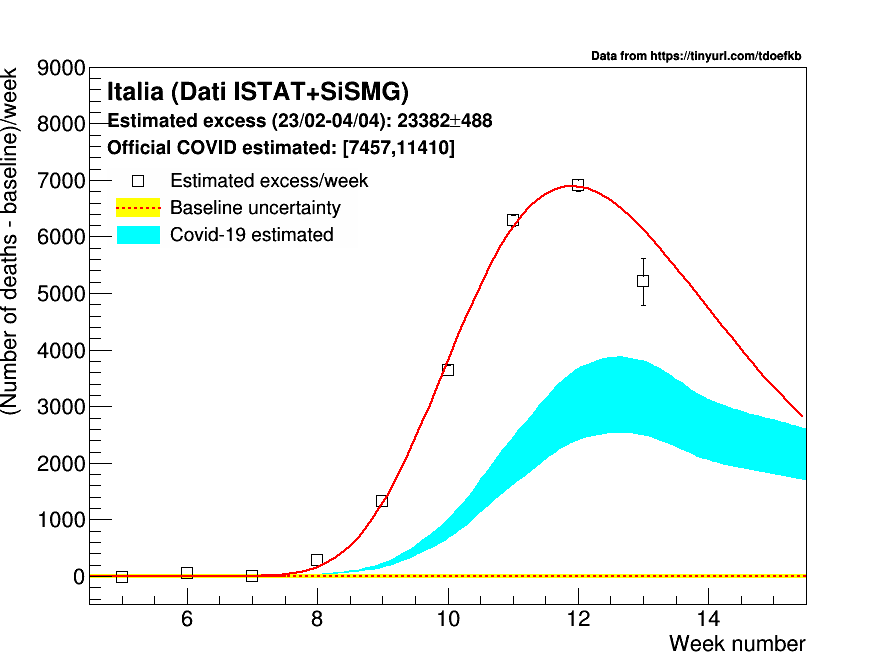

In [51]:
maxX=15.5
xP=n.linspace(4.5,maxX,100)
yP=n.zeros(100)
yE=n.zeros(100)
leg=R.TLegend(0.12,0.75,0.4,0.63)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)       


R.gStyle.SetOptTitle(0)
for p in ['nazionale']:
    dgompertz.SetParameter(0,30000)
    dgompertz.SetParameter(2,0.1)
    dgompertz.SetParameter(1,1)
    dgompertz.SetParameter(3,10)
    
    a=R.TH2F('a','a',10,4.5,maxX,10,-500,9000)
    a.GetXaxis().SetTitle("Week number")
    a.GetYaxis().SetTitle("(Number of deaths - baseline)/week")
    a.SetStats(0)
    a.Draw()

    err=baseline[p]
    graphs['eccesso_deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerStyle(25)
    graphs['eccesso_deceduti_%s'%p].SetMarkerSize(1.4)
    graphs['eccesso_deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['eccesso_deceduti_%s'%p].GetXaxis().SetLimits(firstWeek+0.5,maxX)
    graphs['eccesso_deceduti_%s'%p].GetXaxis().SetRangeUser(firstWeek+0.5,maxX)
    graphs['eccesso_deceduti_%s'%p].GetYaxis().SetTitle("(Number of deaths - baseline)/week")
    fit=graphs['eccesso_deceduti_%s'%p].Fit('dgompertz','RB+')
    #print(fit.Get().Chi2())
    #values = fit.GetConfidenceIntervals(0.95, False)    
    #gFit=R.TGraphErrors()
    #for i,x in enumerate(xP):
    #    gFit.SetPoint(i, x, dgompertz.Eval(x))
    #    gFit.SetPointError(i, 0, 0) 


    #fit.GetConfidenceIntervals(gFit)
    graphs['eccesso_deceduti_%s'%p].Draw("PSAME")
    
    smoothed=smooth2.SmoothKern(graphs['eccesso_deceduti_%s'%p],'normal',1.5)
    smoothed.SetName('eccesso_deceduti_smoothed')
    smoothed.SetLineColor(R.kBlack)
    smoothed.SetLineWidth(3)
    smoothed.SetLineStyle(2)
                                       
    smoothedExt1=smooth1.SmoothKern(graphs['deceduti_official_nazionale'],'normal',1.5)
    smoothedExt1.SetName('deceduti_official_nazionale_smoothed')
    smoothedExt1.SetLineColor(R.kMagenta+1)
    smoothedExt1.SetLineWidth(8)
    
    smoothedExt=smooth.SmoothKern(graphs['deceduti_official_rescaled_nazionale'],'normal',1.5)
    smoothedExt.SetName('deceduti_official_rescaled_nazionale_smoothed')
    smoothedExt.SetLineColor(R.kGreen+1)
    smoothedExt.SetLineWidth(8)
    
    band=errorGraphBand(smoothedExt,smoothedExt1)
    band.SetFillColor(R.kCyan)
    band.SetLineColor(0)
    
    box=R.TBox(firstWeek+0.5,-err,maxX,err)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(firstWeek+0.5,0,maxX,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line.Draw()
    line1=R.TLine(referenceWeek-0.5,0,7.5,0)
    line1.SetLineColor(R.kRed)
    line1.SetLineStyle(1)
    line1.SetLineWidth(2)
    line1.Draw()
    #smoothedExt.Draw("LSAME")
    #smoothedExt1.Draw("LSAME")
    #band.Print()
    band.Draw("3SAME")
    #graphs['deceduti_official_rescaled_%s'%p].SetLineColor(R.kGreen+1)
    #graphs['deceduti_official_rescaled_%s'%p].SetLineWidth(8)
    #graphs['deceduti_official_rescaled_%s'%p].Draw('CSAME')
    #line.Draw()
    #line1.Draw()
    
    

    #graphs['deceduti_official_%s'%p].SetLineColor(R.kMagenta+1)
    #graphs['deceduti_official_%s'%p].SetLineWidth(8)
    #graphs['deceduti_official_rescaled_%s'%p].Draw('CSAME')

    #smoothed.Draw('LSAME')


    #gFit.SetFillColor(R.kCyan)
    #gFit.Draw('3SAME')
    #dgompertz.Draw('SAME')
    graphs['eccesso_deceduti_%s'%p].Draw("PSAME")

    totalExcess[p]=integralGraph(graphs['eccesso_deceduti_%s'%(p)],8-firstWeek)
    totalErr=R.TMath.Sqrt((err*4)**2+totalExcess[p][1]**2)
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.81,'Estimated excess (23/02-04/04): %.0f#pm%.0f'%(totalExcess[p][0],totalErr))

    totalExcessRescaledCovid=integralGraph(graphs['deceduti_official_rescaled_nazionale'],0,len(weeks)-8+1)
    totalExcessCovid=integralGraph(graphs['deceduti_official_nazionale'],0,len(weeks)-8+1)
    
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.77,'Official COVID estimated: [%.0f,%.0f]'%(totalExcessRescaledCovid[0],totalExcessRescaledCovid[0]+(totalExcessCovid[0]-totalExcessRescaledCovid[0])*0.5))

    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,'Italia (Dati ISTAT+SiSMG)')
    
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    aux=R.TGraph()
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    aux.SetLineStyle(2)
    leg.AddEntry(graphs['eccesso_deceduti_%s'%p],'Estimated excess/week','P')
    leg.AddEntry(aux,'Baseline uncertainty','FL')
    #leg.AddEntry(smoothedExt1,'Covid-19 official ','L')
    #leg.AddEntry(smoothedExt,'Covid-19 rescaled','L')
    leg.AddEntry(band,'Covid-19 estimated','F')
    
    leg.Draw()
    c1.RedrawAxis()
    c1.Draw()

    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA_ISTAT/deathExcess_{:s}".format(p)+ext)

In [52]:
for p in n.unique(dfByRegion['denominazione_regione']):
    df[p]=dfByRegion[dfByRegion['denominazione_regione']==p]

In [53]:
regionsToCompare=[
    'Lombardia',
    'Piemonte',
    'Veneto',
    'Emilia-Romagna',
    'Marche',
    'Lazio',
    'Liguria',
    'Toscana',
    'Sicilia',
    'Umbria'
]

limits={
    'deceduti':                   0,
    'terapia_intensiva':          1E-4*1E6,
    'totale_ospedalizzati':       1E-3*1e6,
    'nuovi_positivi': 0,
    'variazione_totale_positivi': 0,
    'dimessi_guariti': 0
}

keys={
    'deceduti'
}

dayDiff=2
for ip,p in enumerate(regionsToCompare):
    oldWeek=0
    for ik,k in enumerate(keys):
        graphs['%s_official_rescaled_%s'%(k,p)]=R.TGraphErrors()
        graphs['%s_official_rescaled_%s'%(k,p)].SetName('%s_official_rescaled_%s'%(k,p))
        graphs['%s_official_%s'%(k,p)]=R.TGraphErrors()
        graphs['%s_official_%s'%(k,p)].SetName('%s_official_%s'%(k,p))
        for i,ni in enumerate(df[p][k]):
            if((i+dayDiff)%7==0 or i==(len(df[p][k])-1)):
                weekD=float(ni)-oldWeek
                oldWeek=float(ni)
                if ((i+dayDiff)%7==0):
                    weekN=int((i+dayDiff-1)/7)
                else:
                    weekN=int((i+dayDiff-1)/7)
                    #print('Rescaling last week %.1f %.2f'%(weekD,7/((i+dayDiff)%7)))
                    weekD=weekD*7/((i+dayDiff)%7)
                #if ((weekN+8)>len(weeks)):
                #    continue
                print(i,p,weekN+8,weekD,oldWeek)
                graphs['%s_official_rescaled_%s'%(k,p)].SetPoint(weekN,weekN+8,weekD*rescalingFactor[p])
                graphs['%s_official_rescaled_%s'%(k,p)].SetPointError(weekN,0,0)
                graphs['%s_official_%s'%(k,p)].SetPoint(weekN,weekN+8,weekD)
                graphs['%s_official_%s'%(k,p)].SetPointError(weekN,0,0)


5 Lombardia 8 23.0 23.0
12 Lombardia 9 131.0 154.0
19 Lombardia 10 812.0 966.0
26 Lombardia 11 2129.0 3095.0
33 Lombardia 12 2849.0 5944.0
40 Lombardia 13 2712.0 8656.0
47 Lombardia 14 1855.0 10511.0
54 Lombardia 15 1539.0 12050.0
59 Lombardia 16 1246.0 12940.0
5 Piemonte 8 0.0 0.0
12 Piemonte 9 5.0 5.0
19 Piemonte 10 54.0 59.0
26 Piemonte 11 179.0 238.0
33 Piemonte 12 379.0 617.0
40 Piemonte 13 511.0 1128.0
47 Piemonte 14 505.0 1633.0
54 Piemonte 15 619.0 2252.0
59 Piemonte 16 529.2 2630.0
5 Veneto 8 2.0 2.0
12 Veneto 9 11.0 13.0
19 Veneto 10 42.0 55.0
26 Veneto 11 91.0 146.0
33 Veneto 12 216.0 362.0
40 Veneto 13 245.0 607.0
47 Veneto 14 224.0 831.0
54 Veneto 15 228.0 1059.0
59 Veneto 16 205.8 1206.0
5 Emilia-Romagna 8 4.0 4.0
12 Emilia-Romagna 9 44.0 48.0
19 Emilia-Romagna 10 193.0 241.0
26 Emilia-Romagna 11 474.0 715.0
33 Emilia-Romagna 12 629.0 1344.0
40 Emilia-Romagna 13 633.0 1977.0
47 Emilia-Romagna 14 504.0 2481.0
54 Emilia-Romagna 15 484.0 2965.0
59 Emilia-Romagna 16 425.6 326

 FCN=1.85935 FROM HESSE     STATUS=NOT POSDEF     23 CALLS         245 TOTAL
                     EDM=6.14704e-10    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.93477e+04   2.33398e+03   4.39968e-06  -6.07588e-04
   2  p1           1.16981e+00   1.78390e+00   1.80898e-06   2.29310e-03
   3  p2           5.67794e-01   6.15449e-02   2.05203e-06   4.52540e-04
   4  p3           1.11682e+01   2.63857e+00   3.96724e-06   1.04561e-03
 FCN=1.07364 FROM HESSE     STATUS=NOT POSDEF     23 CALLS         487 TOTAL
                     EDM=9.89302e-07    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.20089e+03   2.29552e+03   2.86696e-06   3.15399e-02
   2  p1           2.42640e+00   

Warning in <TROOT::Append>: Replacing existing TH1: a (Potential memory leak).
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Lombardia.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Lombardia.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Lombardia.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: a (Potential memory leak).
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Piemonte.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Piemonte.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_Piemonte.root has been created
Warni

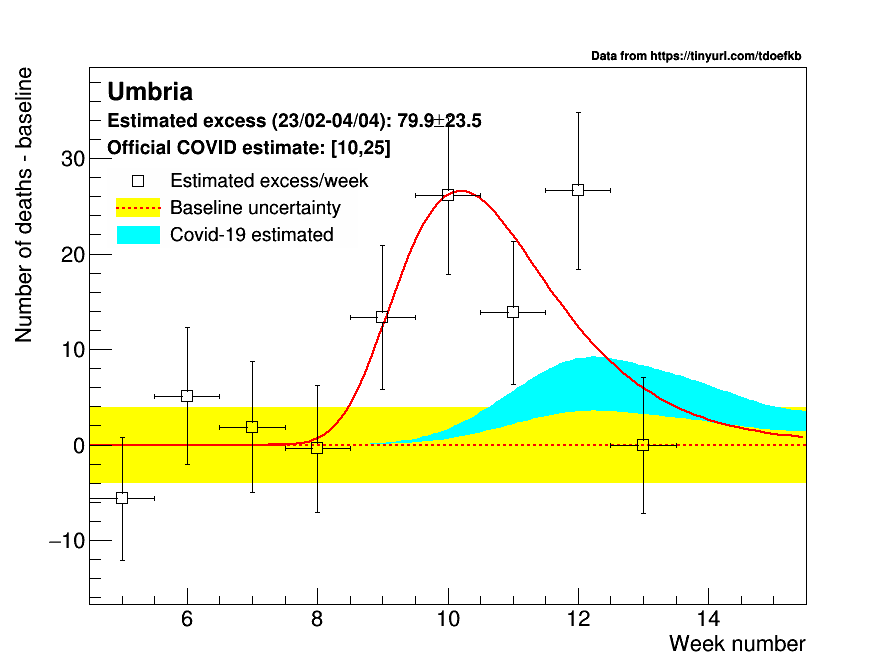

In [54]:
leg=R.TLegend(0.12,0.75,0.4,0.63)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)       

maxX=15.5

for p in regionsToCompare:
    leg.Clear()
    dgompertz.SetParameter(0,30000)
    dgompertz.SetParameter(2,0.1)
    dgompertz.SetParameter(1,1)
    dgompertz.SetParameter(3,10)
    graphs['eccesso_deceduti_corrected_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['eccesso_deceduti_corrected_%s'%p].GetXaxis().SetLimits(4.5,maxX)
    graphs['eccesso_deceduti_corrected_%s'%p].GetXaxis().SetRangeUser(4.5,maxX)
    graphs['eccesso_deceduti_corrected_%s'%p].Draw("AP")
    graphs['eccesso_deceduti_corrected_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")
    histo=graphs['eccesso_deceduti_corrected_%s'%p].GetHistogram()
    a=R.TH2F('a','a',10,4.5,maxX,10,histo.GetMinimum(),histo.GetMaximum())
    a.GetXaxis().SetTitle("Week number")
    a.GetYaxis().SetTitle("Number of deaths - baseline")
    a.SetStats(0)
    a.Draw()
    
    smoothed=smooth2.SmoothKern(graphs['eccesso_deceduti_corrected_%s'%p],'normal',1.5)
    smoothed.SetName('eccesso_deceduti_smoothed')
    smoothed.SetLineColor(R.kBlack)
    smoothed.SetLineWidth(3)
    smoothed.SetLineStyle(2)
    
    baseline_stdev=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)
    #box=R.TBox(firstWeek+0.5,-baseline_stdev,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5,baseline_stdev)
    box=R.TBox(firstWeek+0.5,-baseline_stdev,maxX,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    #line=R.TLine(firstWeek+0.5,0,graphs['eccesso_deceduti_%s'%p].GetN()+firstWeek+0.5,0)
    line=R.TLine(firstWeek+0.5,0,maxX,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line1=R.TLine(referenceWeek-0.5,0,7.5,0)
    line1.SetLineColor(R.kRed)
    line1.SetLineStyle(1)
    line1.SetLineWidth(2)

    graphs['deceduti_official_rescaled_%s'%p].SetLineColor(R.kGreen+1)
    graphs['deceduti_official_rescaled_%s'%p].SetLineWidth(8)
    #graphs['deceduti_official_rescaled_%s'%p].Draw('CSAME')
    line.Draw()
    line1.Draw()
    
    smoothedExt=smooth.SmoothKern(graphs['deceduti_official_rescaled_%s'%p],'normal',2)
    smoothedExt.SetLineColor(R.kGreen+1)
    smoothedExt.SetLineWidth(8)
    #smoothedExt.Draw("LSAME")

    #graphs['deceduti_official_%s'%p].SetLineColor(R.kMagenta+1)
    #graphs['deceduti_official_%s'%p].SetLineWidth(8)
    #graphs['deceduti_official_rescaled_%s'%p].Draw('CSAME')
    smoothedExt1=smooth1.SmoothKern(graphs['deceduti_official_%s'%p],'normal',2)
    smoothedExt1.SetLineColor(R.kMagenta+1)
    smoothedExt1.SetLineWidth(8)
    #smoothedExt1.Draw("LSAME")

    band=errorGraphBand(smoothedExt,smoothedExt1)
    band.SetFillColor(R.kCyan)
    band.SetLineColor(0)
    
    line.Draw()
    line1.Draw()

    band.Draw('3SAME')
    #smoothed.Draw('LSAME')
    graphs['eccesso_deceduti_corrected_%s'%p].Fit('dgompertz','R0B')
    dgompertz.Draw('SAME')
    graphs['eccesso_deceduti_corrected_dgompertz_%s'%p]=dgompertz.Clone('eccesso_deceduti_corrected_dgompertz_%s'%p)
    graphs['eccesso_deceduti_corrected_%s'%p].Draw("PSAME")
    totalExcessErr=R.TMath.Sqrt(totalExcess[p][1]**2+(baseline_stdev*4)**2)
           
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.81,'Estimated excess (23/02-04/04): %.1f#pm%.1f'%(totalExcess[p][0],totalExcessErr))

    totalExcessRescaledCovid=integralGraph(graphs['deceduti_official_rescaled_%s'%p],0,len(weeks)-8+1)
    totalExcessCovid=integralGraph(graphs['deceduti_official_%s'%p],0,len(weeks)-8+1)
    
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.77,'Official COVID estimate: [%.0f,%.0f]'%(totalExcessRescaledCovid[0],totalExcessRescaledCovid[0]+(totalExcessCovid[0]-totalExcessRescaledCovid[0])*0.5))


    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)

    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    aux=R.TGraph()
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    aux.SetLineStyle(2)
    
    leg.AddEntry(graphs['eccesso_deceduti_%s'%p],'Estimated excess/week','P')
    leg.AddEntry(aux,'Baseline uncertainty','FL')
    #leg.AddEntry(smoothedExt1,'Covid-19 official ','L')
    #leg.AddEntry(smoothedExt,'Covid-19 rescaled','L')
    leg.AddEntry(band,'Covid-19 estimated','F')
    leg.Draw()
    
    c1.RedrawAxis()
    c1.Draw()
    
    sumTotal+=totalExcess[p][0]
    sumTotalRescaled+=totalExcess[p][0]/rescalingFactor[p]
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA_ISTAT/deathExcessComparison_{:s}".format(p)+ext)

In [55]:
#baseline={ p:graphs['deceduti_%s'%p].GetFunction('fB').GetParameter(0) for p in regionsToCompare }
#baselineRescaled={ p:graphs['deceduti_%s'%p].GetFunction('fB').GetParameter(0)*52/populationIstatByRegion[p] for p in regionsToCompare }

In [56]:
#graphs['baselineRescaled']=R.TH1F('baselineRescaled','baselineRescaled')

In [57]:
fOut=R.TFile('~/cernbox/www/plots/COVID19_DA_ISTAT/graphs.root','RECREATE')
for o,g in graphs.items():
    g.Write()
fOut.Write()
fOut.Close()